# Resnet Block

In [1]:
import torch
import ttnn
from ttnn.tracer import trace, visualize
from ttnn.model_preprocessing import preprocess_model

In [2]:
torch.manual_seed(0)
device = ttnn.open_device(device_id=0)

                  Metal | INFO     | Initializing device 0
                 Device | INFO     | Opening user mode device driver
2024-02-13 01:56:46.147 | INFO     | SiliconDriver   - Detected 1 PCI device : {0}
2024-02-13 01:56:46.157 | WARNING  | SiliconDriver   - init_detect_tt_device_numanodes(): Could not determine NumaNodeSet for TT device (physical_device_id: 0 pci_bus_id: 0000:00:08.0)
2024-02-13 01:56:46.157 | WARNING  | SiliconDriver   - Could not find NumaNodeSet for TT Device (physical_device_id: 0 pci_bus_id: 0000:00:08.0)
2024-02-13 01:56:46.159 | WARNING  | SiliconDriver   - bind_area_memory_nodeset(): Unable to determine TT Device to NumaNode mapping for physical_device_id: 0. Skipping membind.
---- ttSiliconDevice::init_hugepage: bind_area_to_memory_nodeset() failed (physical_device_id: 0 ch: 0). Hugepage allocation is not on NumaNode matching TT Device. Side-Effect is decreased Device->Host perf (Issue #893).
                  Metal | INFO     | AI CLK for device 0 is:

## Torch Module (from torchvision)

In [3]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> torch.nn.Conv2d:
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


class TorchBasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample=None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer=None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        # self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        # self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # out += identity
        # out = self.relu(out)

        return out

## Create torch module and preprocess it to get ttnn parameters

In [4]:
torch_model = TorchBasicBlock(inplanes=64, planes=64, stride=1)

torch_input_tensor = torch.rand((8, 64, 56, 56), dtype=torch.float32)

reader_patterns_cache = {}
parameters = preprocess_model(
    initialize_model=lambda: torch_model,
    run_model=lambda model: model(torch_input_tensor),
    reader_patterns_cache=reader_patterns_cache,
    device=device,
)

2024-02-13 01:56:47.222 | WARNING  | ttnn.model_preprocessing:_initialize_model_and_preprocess_parameters:434 - Putting the model in eval mode
2024-02-13 01:56:47.301 | INFO     | ttnn.model_preprocessing:infer_ttnn_module_args:368 - Dumping graph of the model to /tmp/ttnn/model_graph.svg
2024-02-13 01:56:47.346 | INFO     | torchtrail.multidigraph:visualize_graph:316 - Graph visualization saved to "/tmp/ttnn/model_graph.svg"
2024-02-13 01:56:47.550 | INFO     | ttnn.model_preprocessing:preprocess_model:543 - Moving model weights to device
2024-02-13 01:56:47.551 | INFO     | ttnn.model_preprocessing:preprocess_model:545 - Moved model weights to device


## Display the parameters of the module

In [5]:
parameters

{
  conv1: <ttnn.operations.conv.Conv2D object at 0x7f29c3b0fc10>,
  conv2: <ttnn.operations.conv.Conv2D object at 0x7f299d093eb0>
}

## Display the traced torch graph

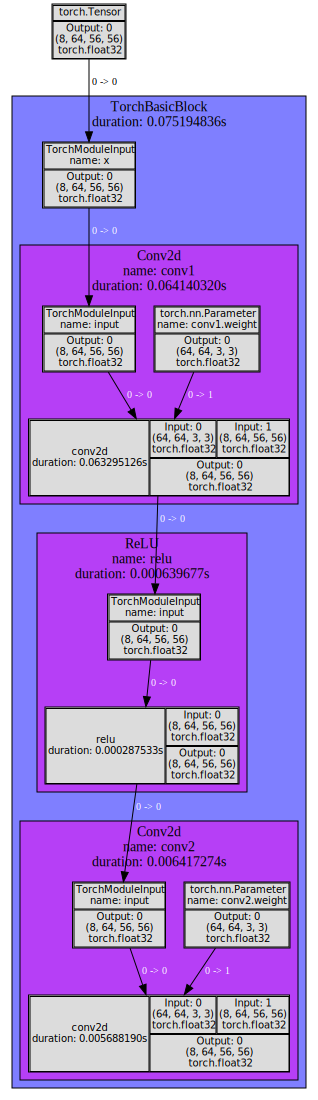

In [6]:
from IPython.display import SVG
SVG('/tmp/ttnn/model_graph.svg')

## Implement ttnn version of the module. Pass in the parameters into the constructor. 

In [7]:
class TTNNBasicBlock:

    def __init__(
        self,
        parameters,
    ) -> None:
        self.conv1 = parameters.conv1
        self.conv2 = parameters.conv2
        if "downsample" in parameters:
            self.downsample = parameters.downsample
        else:
            self.downsample = None

    def __call__(self, x):
        identity = x

        out = self.conv1(x)
        # out = self.bn1(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # out = ttnn.add(out, identity, memory_config=ttnn.get_memory_config(out))
        # out = ttnn.to_memory_config(out, memory_config=ttnn.DRAM_MEMORY_CONFIG)
        # out = self.relu(out)

        return out

def run_conv(conv, torch_input_tensor):
    input_tensor = torch.permute(torch_input_tensor, (0, 2, 3, 1))
    input_tensor = ttnn.from_torch(input_tensor, dtype=ttnn.bfloat16)

    input_tensor = conv.conv1.copy_input_to_device(input_tensor)
    output_tensor = conv(input_tensor)
    output_tensor = conv.conv2.copy_output_from_device(output_tensor)

    output_tensor = ttnn.to_torch(output_tensor)
    output_tensor = torch.permute(output_tensor, (0, 3, 1, 2))
    output_tensor = torch.reshape(output_tensor, torch_input_tensor.shape)
    output_tensor = output_tensor.to(torch_input_tensor.dtype)
    return output_tensor


## Run ttnn module and display the traced graph

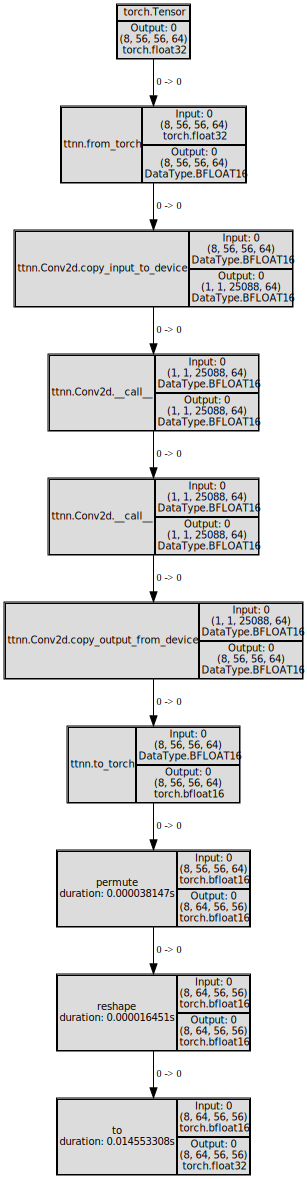

In [8]:
ttnn_model = TTNNBasicBlock(parameters)
with ttnn.tracer.trace():
    output_tensor = run_conv(ttnn_model, torch_input_tensor)
ttnn.tracer.visualize(output_tensor)

In [9]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
